模型定义

In [1]:
import torch
from torch import nn
import numpy as np

class MultiHeadAttention(nn.Module):
    def __init__(self, args):
        super(MultiHeadAttention, self).__init__()

        self.n_head = args.n_heads
        self.d_k = args.d_k
        self.d_v = args.d_v
        self.d_model = args.d_model
    
        self.W_Q = nn.Linear(args.d_model, args.d_k * args.n_heads, bias=False)
        self.W_K = nn.Linear(args.d_model, args.d_k * args.n_heads, bias=False)
        self.W_V = nn.Linear(args.d_model, args.d_v * args.n_heads, bias=False)

    def forward(self, input_Q, input_K, input_V):
        batch_size = input_Q.size(0)
        # (B, S, D) -proj-> (B, S, D_new) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        self.Q = self.W_Q(input_Q).view(batch_size, -1, self.n_head, self.d_k).transpose(1, 2)  # Q: [batch_size, n_heads, len_q, d_k]
        self.K = self.W_K(input_K).view(batch_size, -1, self.n_head, self.d_k).transpose(1, 2)  # K: [batch_size, n_heads, len_k, d_k]
        self.V = self.W_V(input_V).view(batch_size, -1, self.n_head, self.d_v).transpose(1, 2)  # V: [batch_size, n_heads, len_v(=len_k), d_v]

        self.QK = torch.matmul(self.Q, self.K.transpose(-1, -2)/ np.sqrt(self.d_k))  # QK: [batch_size, n_heads, len_q, len_k]
        self.softmaxQK = nn.Softmax(dim=-1)(self.QK)
        self.QKV = torch.matmul(self.softmaxQK, self.V).transpose(1, 2).reshape(batch_size, -1, self.n_head * self.d_v)

        return self.QKV


class DecoderLayer(nn.Module):
    def __init__(self, args):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention(args)

    def forward(self, hidden_state):
        # Attention层
        hidden_state = self.dec_self_attn(hidden_state, hidden_state, hidden_state)

        return hidden_state


class Decoder(nn.Module):
    def __init__(self, args, device):
        super(Decoder, self).__init__()
        self.device = device
        self.layers = nn.ModuleList([DecoderLayer(args) for _ in range(args.n_layers)])

    def forward(self, hidden_state):

        for i, layer in enumerate(self.layers):
            hidden_state = layer(hidden_state)

        return hidden_state


class Embedding(nn.Module):
    def __init__ (self, args, device):
        super(Embedding, self).__init__()
        self.device = device
        self.tgt_emb = nn.Embedding(args.vocab_size, args.d_model)
        self.pos_emb = nn.Embedding(args.max_pos, args.d_model)

    def forward(self, X_input):
        seq_len = X_input.size(1)
        pos = torch.arange(seq_len, dtype = torch.long, device = self.device)
        pos = pos.unsqueeze(0).expand_as(X_input)

        self.tgt = self.tgt_emb(X_input)
        self.pos = self.pos_emb(pos)
        self.emb = self.tgt + self.pos

        return self.emb

class myGPT_lightly(nn.Module):
    def __init__(self, args, device):
        super(myGPT_lightly, self).__init__()

        self.device = device

        self.embedding = Embedding(args, device)
        self.decoder = Decoder(args, device)


    def forward(self, X_input):
        """
            hidden_state: [batch_size, tgt_len]
        """
        hidden_state = self.embedding(X_input)

        hidden_state = self.decoder(hidden_state)
        
        dec_logits = hidden_state
        return dec_logits.view(-1, dec_logits.size(-1))

模型加载

In [2]:
import sys
sys.path.append('../')
import torch
from utils import *
from data import *

exp_dir = '../result/GPT_lightly_2层_1head_3x_to_x'
working_dir = f'{exp_dir}/3x_to_x_new_interval-seed_2-N_30000-2Decoder_无mask_无projection'
state_dict=torch.load(f'{working_dir}/model/model_9999.pt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = load_args(f'{working_dir}/config.json')

model = myGPT_lightly(args, device)
model.load_state_dict(state_dict)
model.to(device)

myGPT_lightly(
  (embedding): Embedding(
    (tgt_emb): Embedding(201, 201)
    (pos_emb): Embedding(20, 201)
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-1): 2 x DecoderLayer(
        (dec_self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=201, out_features=201, bias=False)
          (W_K): Linear(in_features=201, out_features=201, bias=False)
          (W_V): Linear(in_features=201, out_features=201, bias=False)
        )
      )
    )
  )
)

函数定义

In [4]:
def get_data_dic(model: myGPT_lightly):
    datas = {}
    datas['total_tgt_emb'] = model.embedding.tgt_emb.weight.detach().cpu().numpy()
    datas['total_pos_emb'] = model.embedding.pos_emb.weight.detach().cpu().numpy()
    datas['pos_emb'] = model.embedding.pos[0].detach().cpu().numpy()
    datas['tgt_emb'] = model.embedding.tgt[0].detach().cpu().numpy()
    datas['emb'] = model.embedding.emb[0].detach().cpu().numpy()
    datas['WQ1'] = model.decoder.layers[0].dec_self_attn.W_Q.weight.detach().cpu().numpy()
    datas['WK1'] = model.decoder.layers[0].dec_self_attn.W_K.weight.detach().cpu().numpy()
    datas['WV1'] = model.decoder.layers[0].dec_self_attn.W_V.weight.detach().cpu().numpy()
    datas['Q1'] = model.decoder.layers[0].dec_self_attn.Q[0][0].detach().cpu().numpy()
    datas['K1'] = model.decoder.layers[0].dec_self_attn.K[0][0].detach().cpu().numpy()
    datas['V1'] = model.decoder.layers[0].dec_self_attn.V[0][0].detach().cpu().numpy()
    datas['QK1'] = model.decoder.layers[0].dec_self_attn.QK[0][0].detach().cpu().numpy()
    datas['softmaxQK1'] = model.decoder.layers[0].dec_self_attn.softmaxQK[0][0].detach().cpu().numpy()
    datas['QKV1'] = model.decoder.layers[0].dec_self_attn.QKV[0].detach().cpu().numpy()
    datas['WQ2'] = model.decoder.layers[1].dec_self_attn.W_Q.weight.detach().cpu().numpy()
    datas['WK2'] = model.decoder.layers[1].dec_self_attn.W_K.weight.detach().cpu().numpy()
    datas['WV2'] = model.decoder.layers[1].dec_self_attn.W_V.weight.detach().cpu().numpy()
    datas['Q2'] = model.decoder.layers[1].dec_self_attn.Q[0][0].detach().cpu().numpy()
    datas['K2'] = model.decoder.layers[1].dec_self_attn.K[0][0].detach().cpu().numpy()
    datas['V2'] = model.decoder.layers[1].dec_self_attn.V[0][0].detach().cpu().numpy()
    datas['QK2'] = model.decoder.layers[1].dec_self_attn.QK[0][0].detach().cpu().numpy()
    datas['softmaxQK2'] = model.decoder.layers[1].dec_self_attn.softmaxQK[0][0].detach().cpu().numpy()
    datas['QKV2'] = model.decoder.layers[1].dec_self_attn.QKV[0].detach().cpu().numpy()

    return datas

def softmax(x, mask=False):
    if len(x.shape) == 1:
        return np.exp(x) / np.sum(np.exp(x))
    else:
        if mask:
            # 将上半部分替换成-1e9
            x1 = np.tril(x)
            x1[x1==0] = -1e9
            x1 = np.exp(x1)
        else:
            x1 = np.exp(x)
        return x1 / np.sum(x1, axis=1, keepdims=True)

def plot_single_show(data, save_name=None, save=False):
    fig = plt.figure(figsize=(8, 8))
    format_settings(ms=5, major_tick_len=0, fs=12, axlw=3, left=0.01, right=0.99, bottom=0.01, top=0.99)
    ax = plt.gca()
    im = plt.imshow(data, cmap='viridis')
    # cbar = plt.colorbar(im, orientation='horizontal')

    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_xticklabels([])

    if save:
        plt.savefig(f'analysis/{save_name}.png', dpi=300)

获取数据

In [5]:
seq = [25, 36, 50, 67, 3, 44, 43, 92, 87]
dec_logits = model(torch.tensor([seq]).to(device))
datas = get_data_dic(model)
pos_3 = seq.index(3)

attention矩阵

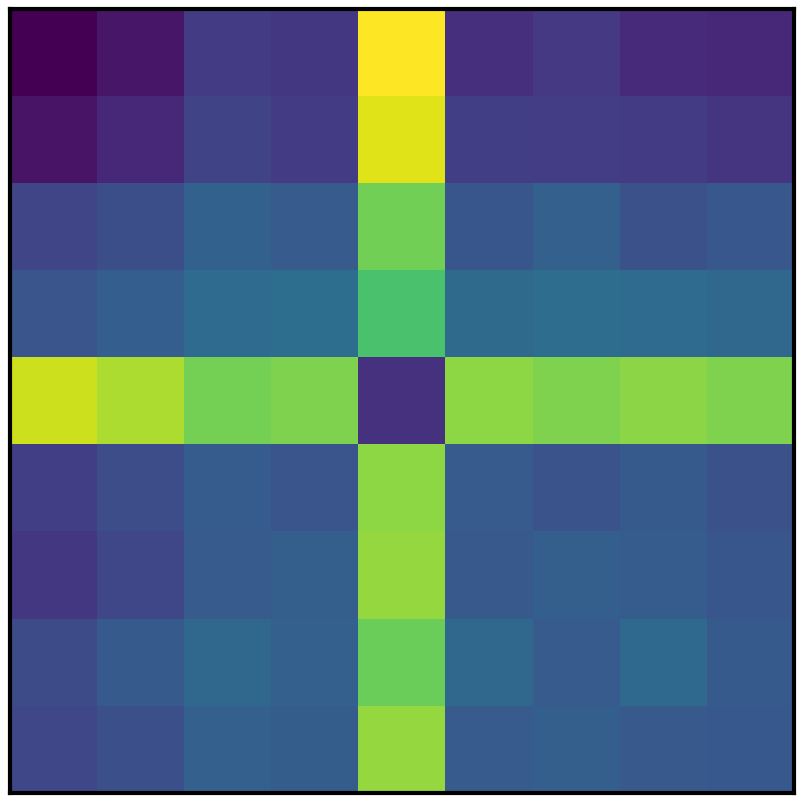

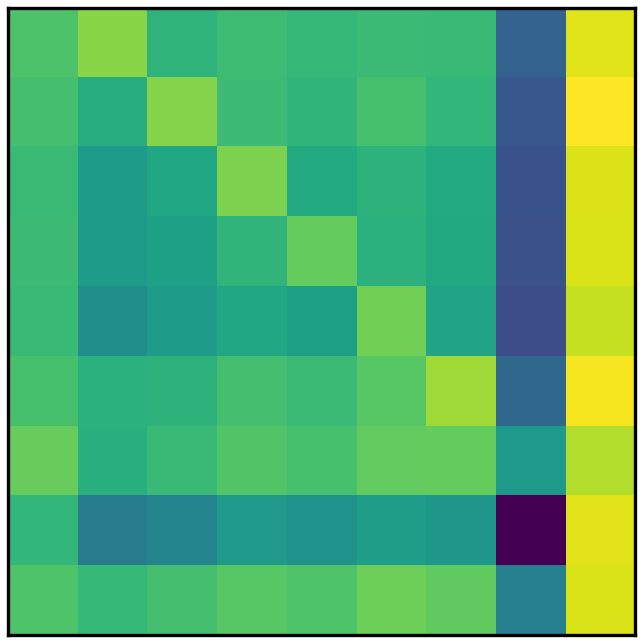

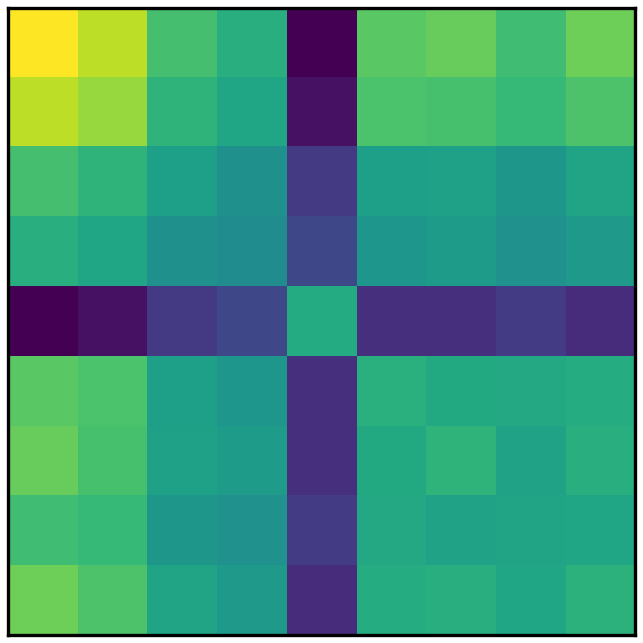

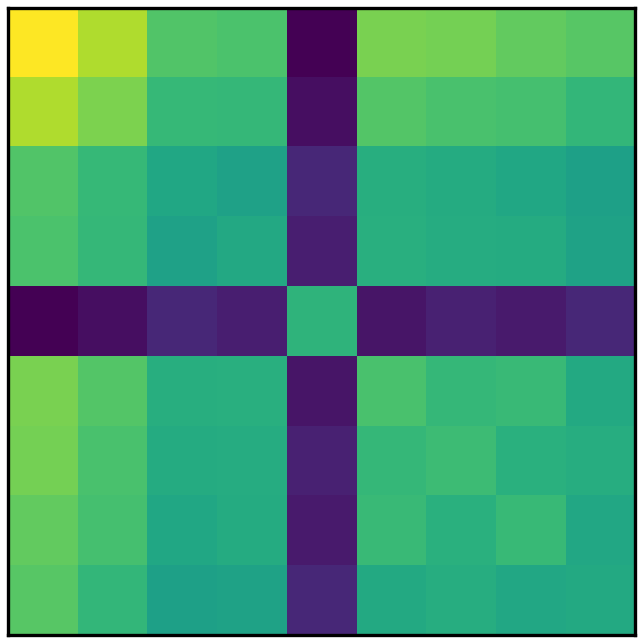

In [6]:
X0 = datas['total_tgt_emb'][seq].copy()

Q_x = np.matmul(X0, datas['WQ1'].T)
K_x = np.matmul(X0, datas['WK1'].T)
QK_xx = np.matmul(Q_x, K_x.T) / np.sqrt(201)

X_p = datas['pos_emb'].copy()
Q_p = np.matmul(X_p, datas['WQ1'].T)
K_p = np.matmul(X_p, datas['WK1'].T)
QK_pp = np.matmul(Q_p, K_p.T) / np.sqrt(201)

plot_single_show(QK_xx, f'QK_xx')
plot_single_show(QK_pp, f'QK_pp')

QQ_xx = np.matmul(Q_x, Q_x.T) / np.sqrt(201)
KK_xx = np.matmul(K_x, K_x.T) / np.sqrt(201)
plot_single_show(QQ_xx, f'QQ_xx')
plot_single_show(KK_xx, f'KK_xx')


$XW^{v1}W^{v2}$

[]

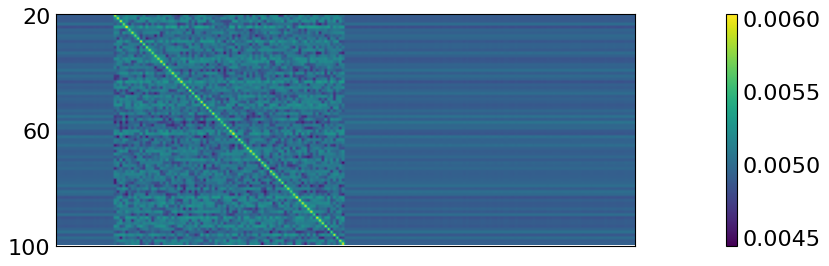

In [7]:
tmp = np.matmul(datas['total_tgt_emb'], datas['WV1'].T)
tmp = np.matmul(tmp, datas['WV2'].T)
tmp = softmax(tmp[20:100]/201)

fig = plt.figure(figsize=(24, 5))
format_settings(ms=5, major_tick_len=0, fs=20, axlw=1, left=0.05, right=0.99, bottom=0.41, top=0.99)
ax = plt.gca()
im = ax.imshow(tmp, cmap='viridis')

cbar = plt.colorbar(im)
                    
# y轴坐标刻度
ax.set_yticks([0, 40, 80])
ax.set_yticklabels([20, 60, 100])
ax.set_xticks([])
ax.set_xticklabels([])

向量平行性

In [6]:
def plot_single_show2(data):
    fig = plt.figure(figsize=(16, 8))
    format_settings(ms=5, major_tick_len=0, fs=12, axlw=0, left=0.01, right=0.99, bottom=0.01, top=0.99)
    ax = plt.gca()
    im = plt.imshow(data, cmap='viridis')
    cbar = plt.colorbar(im, orientation='horizontal')

    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_xticklabels([])

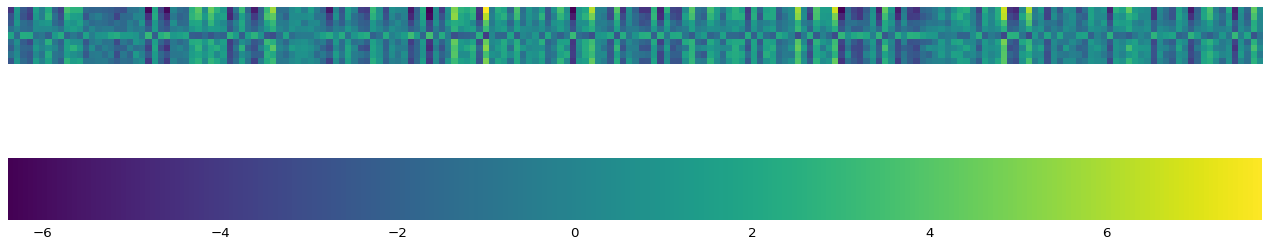

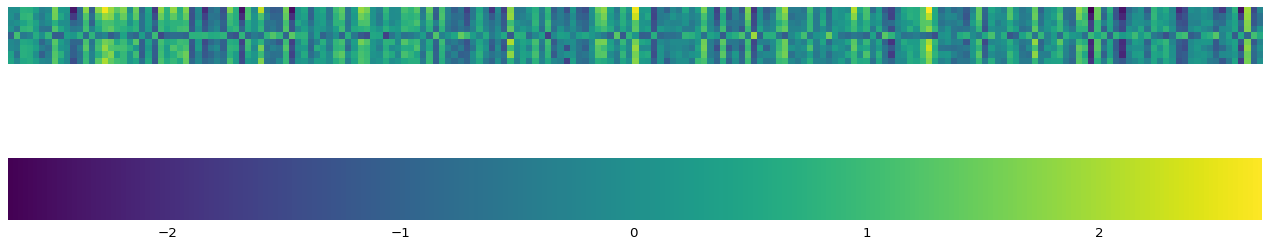

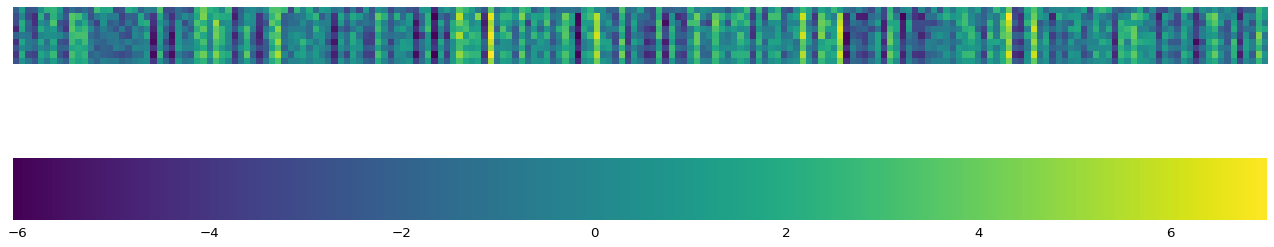

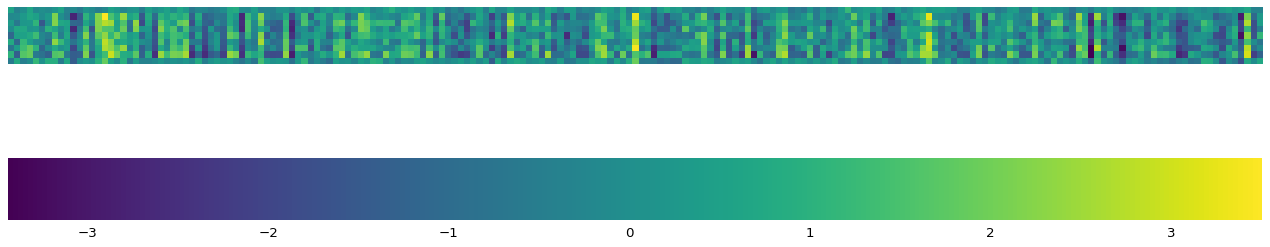

In [32]:
X0 = datas['total_tgt_emb'][seq].copy()

Q_x = np.matmul(X0, datas['WQ1'].T)
K_x = np.matmul(X0, datas['WK1'].T)
QK_xx = np.matmul(Q_x, K_x.T) / np.sqrt(201)

plot_single_show2(Q_x)
plot_single_show2(K_x)

X_p = datas['pos_emb'].copy()
Q_p = np.matmul(X_p, datas['WQ1'].T)
K_p = np.matmul(X_p, datas['WK1'].T)
QK_pp = np.matmul(Q_p, K_p.T) / np.sqrt(201)

plot_single_show2(Q_p)
plot_single_show2(K_p)

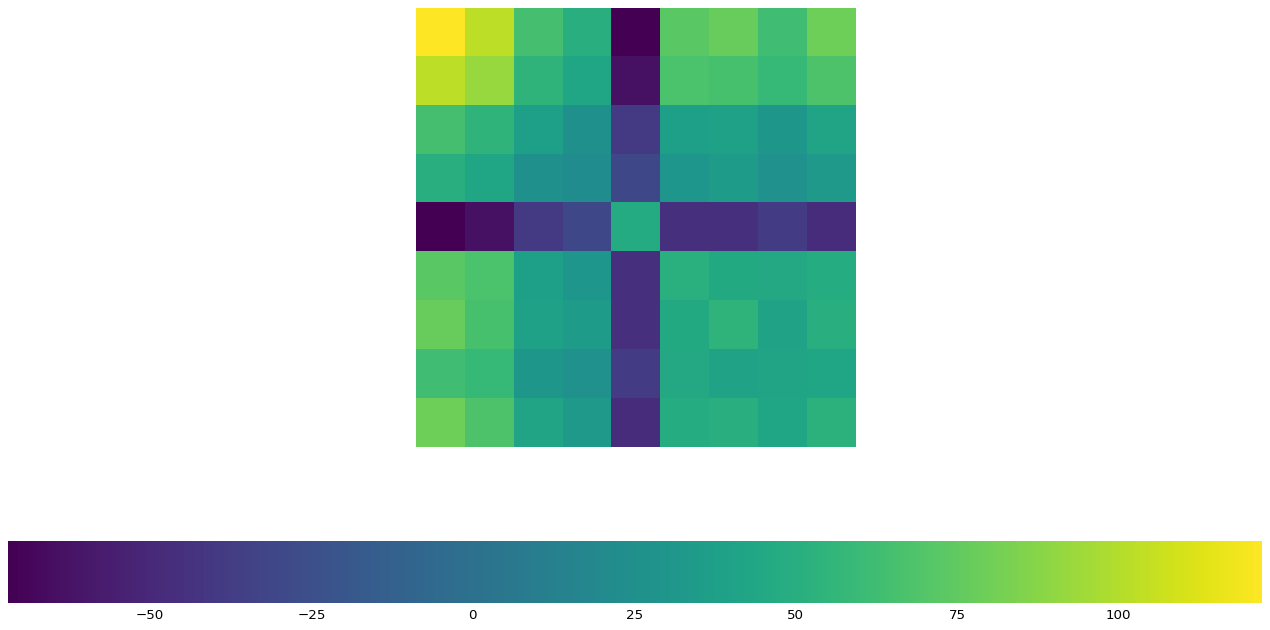

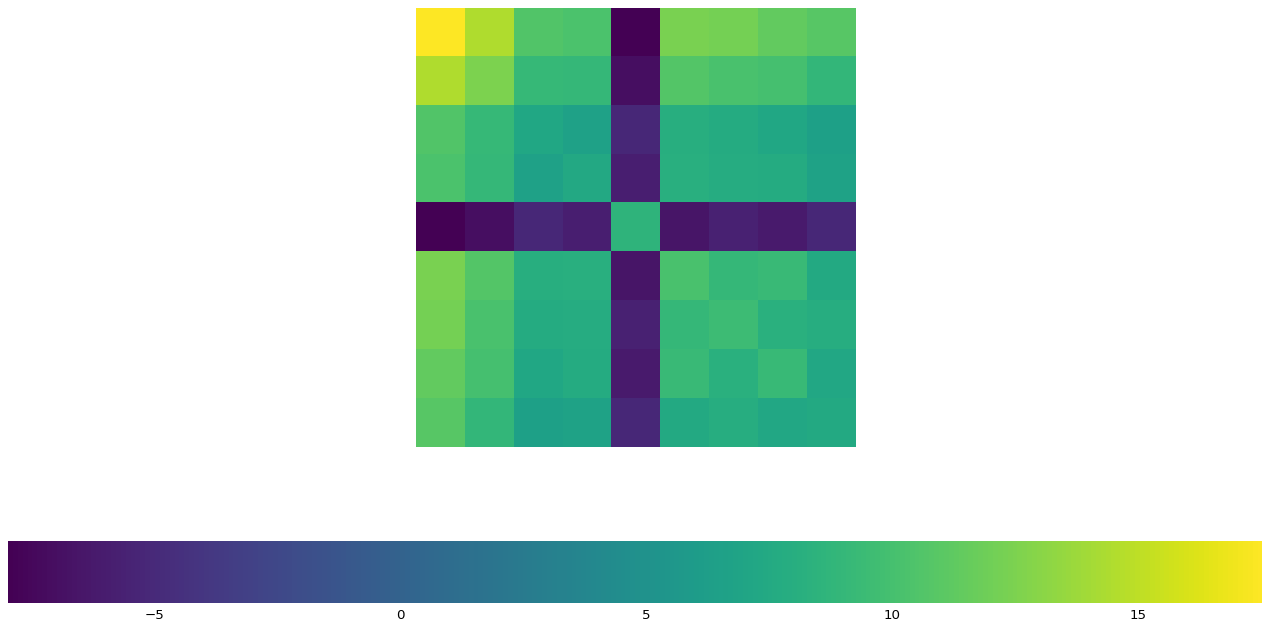

In [8]:
X0 = datas['total_tgt_emb'][seq].copy()

Q_x = np.matmul(X0, datas['WQ1'].T)
K_x = np.matmul(X0, datas['WK1'].T)
QQ_xx = np.matmul(Q_x, Q_x.T) / np.sqrt(201)
KK_xx = np.matmul(K_x, K_x.T) / np.sqrt(201)

plot_single_show2(QQ_xx)
plot_single_show2(KK_xx)

# X_p = datas['pos_emb'].copy()
# Q_p = np.matmul(X_p, datas['WQ1'].T)
# K_p = np.matmul(X_p, datas['WK1'].T)
# QK_pp = np.matmul(Q_p, K_p.T) / np.sqrt(201)

# plot_single_show2(Q_p)
# plot_single_show2(K_p)